# Music Data Analysis

En este notebook vamos a extraer información de Google Analytics de Maestralia y vamos a realizar un **análisis de datos "clásico"** con el que podremos entender un poco más sobre nuestros usuarios y leads. Más tarde realizaremos un **estudio de cluster sobre estos datos**, gracias al cual seremos capaces de observar relaciones que pueden estar ocultas a simple vista. Con ello intentaremos conseguir insights a través de los cuales podremos optimizar nuestra web para conseguir los mejores resultados. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import multidict as multidict
from mpl_toolkits.mplot3d import Axes3D
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

plt.rcParams['figure.figsize'] = (20, 10)
sns.set_style('whitegrid')

### Primer Dataset: entendiendo a nuestros usuarios
En la siguiente celda extraeremos la información de Analytics a través de la URI que ofrece el [Query Explorer de Google Analytics](https://ga-dev-tools.appspot.com/query-explorer/?ids=ga%3A194100931&start-date=2019-10-01&end-date=yesterday&metrics=ga%3Agoal1Completions%2Cga%3Agoal4Completions&dimensions=ga%3AsessionCount%2Cga%3AmobileDeviceInfo%2Cga%3Acity%2Cga%3AuserAgeBracket%2Cga%3AuserGender&filters=ga%3AsourceMedium!%3Dt.co%20%2F%20referral&samplingLevel=HIGHER_PRECISION). Esto nos facilita la vida ya que viene **incorporado el token de cliente**, lo que nos permite realizar la llamada sin tener que dar acceso manualmente desde GA. 

Los datos que vamos a extraer en este primer acercamiento son:
    1. Conteo de Sesiones
    2. Modelo de Móvil
    3. Ciudad
    4. Edad
    5. Género
    6. Forms enviados
    7. Clicks del blog hacia cursos
    
Si duplicásemos este archivo para aprovechar este análisis en otro cliente, **deberíamos adaptar estas variables a lo más apropiado para el nuevo análisis**. También deberemos **cambiar el link** desde el que obtenemos el API Query.

In [2]:
path_to_data = "songs_with_audio_features.csv"
data = pd.read_csv(path_to_data, index_col=False, delimiter=";")
data['genre'] = data['genre'].str.replace("'", "")
data['genre'] = data['genre'].str.strip('()').str.split(',')
data = data.explode('genre', ignore_index=True)

In [3]:
genre = data.pop('genre')
artist_name = data.pop('artist_name')
album_name = data.pop('album_name')
ids = data.pop('id')
track_name = data.pop('track_name')
decade = data.pop('decade')
data.drop(columns=['uri', 'track_href', 'analysis_url', 'duration_ms', 'time_signature', 'type'], inplace=True)
genre

0         [classic rock
1          country rock
2                  rock
3            roots rock
4         southern rock
              ...      
29903     [canadian pop
29904         dance pop
29905               pop
29906     post-teen pop
29907        viral pop]
Name: genre, Length: 29908, dtype: object

# Clustering & Lead Segmentation
A falta de datos de venta en los proyectos, vamos a analizar el comportamiento de nuestros leads. Para ello utilizaremos diversas técnicas de clustering, y para ello, debemos cambiar nuestro dataset. **Extraeremos el api queri de [aquí](https://ga-dev-tools.appspot.com/query-explorer/?ids=ga%3A194100931&start-date=2019-10-01&end-date=yesterday&metrics=ga%3AbounceRate%2Cga%3AavgSessionDuration%2Cga%3Agoal1Completions%2Cga%3Agoal4Completions%2Cga%3ApageviewsPerSession%2Cga%3AsessionsPerUser&dimensions=ga%3AuserBucket%2Cga%3AyearWeek&samplingLevel=HIGHER_PRECISION&max-results=10000)**

Para poder realizar este análisis lo ideal sería tener un user-id o un client-id a través del cual pudiéramos identificar a usuarios únicos de alguna manera. Así el modelo de [Clustering](https://en.wikipedia.org/wiki/K-means_clustering) sería capaz de hacer las interrelaciones necesarias con mayor precisión. Sabiendo que este punto no lo tenemos implementado, hemos recogido la variable **User Bucket** que asigna un número aleatorio a los usuarios (asginado por Google). Esto aleatoriedad nos ayuda a que el modelo pueda trabajar en las relaciones queremos, ya que los datos no están sesgados por nuestro juicio.

¿Por qué esto es algo interesante para nosotros? Porque a través de este tipo de análisis podemos **descubrir realmente dónde están nuestros usuarios potenciales y como interactúan con la página**. Teniendo estos datos en la mano podemos comparar nuestros resultados actuales con los "ideales" y observar si estamos dentro del cuadrante correspondiente.

Las variables recogidas en este dataset son las siguientes:
    1. User Bucket
    2. Semana
    3. % Rebote
    4. Media Duración Sesión
    5. Forms Enviados
    6. Clicks desde el blog hacia cursos
    7. Páginas / Sesión
    8. Sesiones por Usuario
    
Igual que en el anterior dataset, si clonásemos este report **deberíamos adaptar estas variables** a lo más adecuado para el análisis.

### Normalization

El siguiente paso recoge las operaciones a realizar para normalizar los datos. Con normalizar lo que queremos decir es que ponemos todas las variables en la misma escala de valores para que el modelo de clustering pueda tratarlos de la misma manera.

In [4]:
x = data.values
x = np.nan_to_num(x)

sc = StandardScaler()
cluster_data = sc.fit_transform(x)

#### Modelo

Entrenamos el modelo con los datos que hemos obtenido en el paso anterior. Esto iterará hasta conseguir la mejor posición de los centroids.

In [5]:
clusters = 8
model = KMeans(init = 'k-means++', n_clusters = clusters, n_init = 12)
model.fit(cluster_data)

labels = model.labels_
data['cluster_num'] = labels

### Resultados Clustering

Una vez tenemos el modelo entrenado con los datos de nuestra muestra, es hora de incorporar los clusters al mismo dataset. En el siguiente paso lo que vamos a observar es la media obtenida en todas las variables dependiendo del cluster al que pertenezcan. Esto es muy importante ya que nos da unas **segmentaciones a las cuales debemos prestar más atención que al resto**. Vamos a sacar unas conclusiones muy breves sobre los resultados que nos arroja este proceso:

    - Los clusters que más nos interesan son el número 1 y el número 2, siendo el primero el mejor cluster. Es interesante observar cosas como las tasas de páginas por sesión o sesiones por usuarios de estos clusters, o la duración media. Es muy parecida en ambos casos, pero la diferencia fundamental entre ambas es el acceso desde el blog. El usuario con entradas desde el blog tiene un rendimiento más bajo que el cluster 1, pero esto, lejos de ser negativo, lo que podría estar representando es un tipo de usuario al que hemos convencido, haciendo que presente unos mejores resultados de los que hubiera tenido.
    - Los clusters de los extremos son los que peor rendimiento presentan, siendo el número 4 una total calamidad en cuanto a conversión. Dada su tasa de rebote -demasiado baja- podríamos atribuirlo a tráfico interno.
    - Por último, el cluster 3 es quizá el más sorprendente de todos: con unas métricas de rendimiento excelentes (rebote, duración, páginas sesión) no consigue convertir ni la mitad de bien que sus primos mayores.
    
Todo esto lo vamos a ver con mayor detalle en las gráficas que nos acompañan, pero este primer acercamiento nos ayudará a comprender mejor a nuestros usuarios.

In [6]:
data.groupby('cluster_num').mean()

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
cluster_num,,,,,,,,,,,,
0,67.931133,0.650603,0.666583,5.956139,-7.881706,0.000000,0.058590,0.177950,0.012303,0.147441,0.641355,117.934739
1,62.567895,0.515911,0.345032,4.948652,-12.700837,0.845104,0.041043,0.581545,0.018819,0.143680,0.430117,114.587547
2,65.051610,0.675394,0.650516,4.956533,-8.627125,1.000000,0.049471,0.214691,0.008713,0.144447,0.760276,116.128647
3,61.555457,0.488079,0.560266,5.375333,-11.834350,0.641526,0.049884,0.315006,0.710671,0.155588,0.486341,117.143039
4,0.728470,0.734647,0.734583,5.314083,-4.948136,0.474164,0.118787,0.179345,0.001424,0.153023,0.639428,127.386729
5,71.421507,0.751472,0.651205,5.900144,-7.051681,0.518483,0.302886,0.147393,0.006012,0.183418,0.574271,118.334075
6,67.097547,0.470596,0.772862,4.920661,-6.167401,0.902081,0.061065,0.089197,0.022259,0.175225,0.469035,138.640441
7,63.637383,0.561771,0.660282,5.516511,-8.635683,0.779439,0.068039,0.264188,0.021793,0.617075,0.619744,118.075028


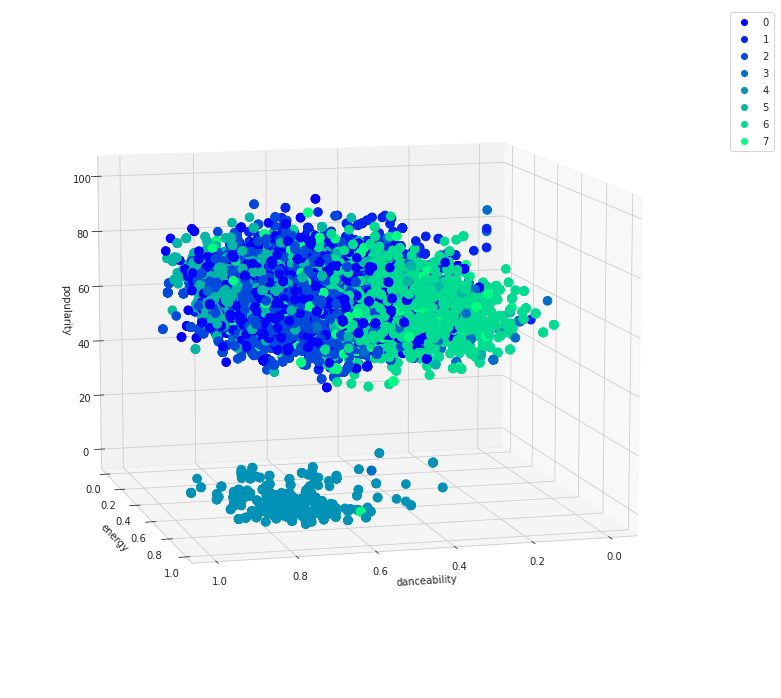

In [7]:
# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, 
            rect = [0, 0, .95, 1], 
            elev = 10, 
            azim = 75,
            auto_add_to_figure=False)
fig.add_axes(ax)
cmap = 'winter'

# plot
sc = ax.scatter(data['danceability'], data['energy'], 
                data['popularity'], s=75, c=data['cluster_num'], marker='o', cmap=cmap, alpha=1)
ax.set_xlabel('danceability')
ax.set_ylabel('energy')
ax.set_zlabel('popularity')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

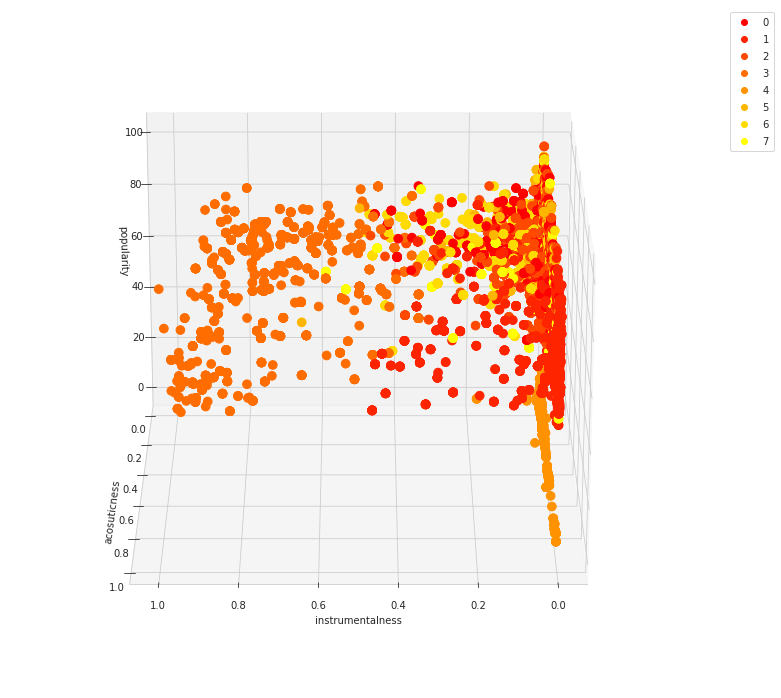

In [8]:
# axes instance
fig = plt.figure(figsize=(10,10))
ax = Axes3D(fig, 
            rect = [0, 0, .95, 1], 
            elev = 22, 
            azim = 90,
            auto_add_to_figure=False)
fig.add_axes(ax)

# plot
sc = ax.scatter(data['instrumentalness'], data['acousticness'], 
                data['popularity'], s=75, c=data['cluster_num'], marker='o', cmap='autumn', alpha=1)
ax.set_xlabel('instrumentalness')
ax.set_ylabel('acosuticness')
ax.set_zlabel('popularity')

# legend
plt.legend(*sc.legend_elements(), bbox_to_anchor=(1.05, 1), loc=2)

## Comprobaciones

Lo que se desprende de las gráficas que vemos aquí y de la tabla de más arriba es que nuestros usuarios ideales (los que más convierten) tienen una serie de características que se repiten en los clusters sobresalientes:

    - La tasa de rebote no debe sobrepasar el 30%. El ideal está entre el 18 y 25%.
    - No se debe sobrepasar las 2.5 páginas por sesión. El ideal está en 1.5-2
    - La duración media de la sesión no debe sobrepasar los 120 segundos (2min). La duración ideal se encuentra entre 75 y 85 segundos.

Para entender si estamos cumpliendo con estas condiciones, lo mejor que podemos hacer es realizar una gráfica con los valores actuales.

In [9]:
#data_to_check.groupby(['genre'])['danceability'].sum().sort_values(ascending=False).plot(kind='bar', figsize=(16,8)) 

In [10]:
data_to_check = data.join([decade, genre, track_name, album_name, artist_name])
data_to_check

,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,cluster_num,decade,genre,track_name,album_name,artist_name
0,82,0.640,0.663,0,-7.516,1,0.0374,0.201,0.00806,0.1520,0.663,132.770,2,1960,[classic rock,Fortunate Son,Willy And The Poor Boys,Creedence Clearwater Revival
1,82,0.640,0.663,0,-7.516,1,0.0374,0.201,0.00806,0.1520,0.663,132.770,2,1960,country rock,Fortunate Son,Willy And The Poor Boys,Creedence Clearwater Revival
2,82,0.640,0.663,0,-7.516,1,0.0374,0.201,0.00806,0.1520,0.663,132.770,2,1960,rock,Fortunate Son,Willy And The Poor Boys,Creedence Clearwater Revival
3,82,0.640,0.663,0,-7.516,1,0.0374,0.201,0.00806,0.1520,0.663,132.770,2,1960,roots rock,Fortunate Son,Willy And The Poor Boys,Creedence Clearwater Revival
4,82,0.640,0.663,0,-7.516,1,0.0374,0.201,0.00806,0.1520,0.663,132.770,2,1960,southern rock,Fortunate Son,Willy And The Poor Boys,Creedence Clearwater Revival
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29903,0,0.759,0.540,9,-6.039,0,0.0287,0.037,0.00000,0.0945,0.750,116.947,4,2020,[canadian pop,Señorita,Kids Summer Party,Shawn Mendes
29904,0,0.759,0.540,9,-6.039,0,0.0287,0.037,0.00000,0.0945,0.750,116.947,4,2020,dance pop,Señorita,Kids Summer Party,Shawn Mendes
29905,0,0.759,0.540,9,-6.039,0,0.0287,0.037,0.00000,0.0945,0.750,116.947,4,2020,pop,Señorita,Kids Summer Party,Shawn Mendes
29906,0,0.759,0.540,9,-6.039,0,0.0287,0.037,0.00000,0.0945,0.750,116.947,4,2020,post-teen pop,Señorita,Kids Summer Party,Shawn Mendes


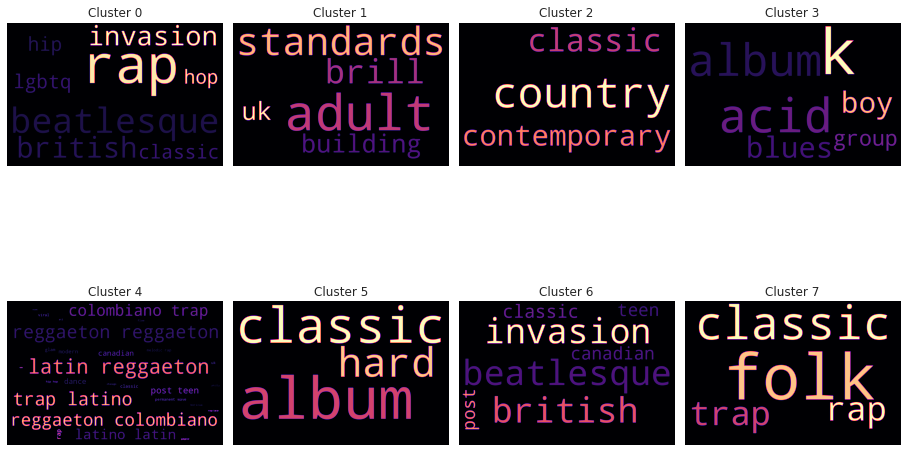

In [11]:
num_clusters = np.unique(data_to_check['cluster_num'])
fig, ax = plt.subplots(int(len(num_clusters)/4),4,figsize=(16,10))

ax = ax.ravel()
ax[-2].set_axis_off()

for i, (cluster, axes) in enumerate(zip(num_clusters, ax)): # One plot per cluster
    generate_data = data_to_check[data_to_check['cluster_num'].isin([cluster])]
    wc = WordCloud(width=750, height=500, random_state=i, margin=20, background_color='black', stopwords=['list', 'pop', 'rock'])
    wc.generate(str(generate_data['genre'].values).replace("'", ""))
    img = wc.to_array()[:,:,0]
    axes.imshow(img, cmap=plt.cm.magma) 
    axes.set_axis_off() # Hide axes
    axes.set_title('Cluster {}'.format(cluster))
    
fig.subplots_adjust(wspace=0.05, hspace=0.05)

In [12]:
data_to_check['pages_session_ideal'] = 1.55
plt.plot(data_to_check.groupby(['Week of Year'])['Pages/Session'].mean(), label = "Páginas/Sesión")
plt.plot(data_to_check.groupby(['Week of Year'])['pages_session_ideal'].mean(), label = "Páginas/Sesión Ideal")
plt.xlabel('Semana del año')
plt.ylabel('Páginas/Sesión')
plt.title('Comparativa Páginas Sesión reales con ideal')
plt.legend()

KeyError: 'Week of Year'

In [ ]:
data_to_check['duration_ideal'] = 80
plt.plot(data_to_check.groupby(['Week of Year'])['Avg. Session Duration'].mean(), label = "Media Duración Sesión")
plt.plot(data_to_check.groupby(['Week of Year'])['duration_ideal'].mean(), label = "Media Duración Sesión Ideal")
plt.xlabel('Semana del año')
plt.ylabel('Media Duración Sesión')
plt.title('Comparativa % Media Duración Sesión real con ideal')
plt.legend()

## Conclusiones

Podemos concluir de nuestro análisis que en las 3 métricas que hemos analizado más a fondo estamos consiguiendo **unos resultados en los últimos meses que se alejan del ideal**.

Tanto en la duración media de las sesiones como en las páginas por sesión nos encontramos bastante por debajo de lo que deberíamos. En el caso del rebote, los resultados se quedan por encima de nuestro modelo ideal.

Es muy importante señalar que, aunque nos encontremos lejos del ideal en estos casos, este análisis no quiere decir que no estemos consiguiendo Leads, ya que estos pueden estar convirtiendo por otros motivos (se genera más cantidad de tráfico y, por tanto, caen más leads al embudo, por ejemplo). **Con este análisis lo que queremos mostrar es cuán cercanos o alejados estamos de conseguir a nuestro público ideal, ese que está más interesado en el producto y tiene una tasa de conversión mayor**.